<a href="https://colab.research.google.com/github/lapidesd/wetted_channels_from_space/blob/main/Colab_notebooks/wetted_channel_random_forest_results_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import math
import matplotlib.ticker as ticker
import matplotlib
!pip install geopandas
import geopandas as gp
%config InlineBackend.figure_format='retina'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load data


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [11]:
# load dry creek data
path = "https://raw.githubusercontent.com/lapidesd/wetted_channels_from_space/main/Data/dry_runoff.csv"
dry_runoff1 = pd.read_csv(path,parse_dates=True,index_col=0)
dry_runoff = dry_runoff1.resample('1D').mean()


In [4]:
# # load data with random forest predictions
# # and then resave them to go in the github repo
# # save this block

# import datetime
# df_alldates = pd.read_csv('/content/drive/MyDrive/Sky_Data/rf_predictions.csv')
# df_alldates['datetime'] = pd.to_datetime(df_alldates.datetime)-datetime.timedelta(hours=7)

# df_new = ''
# for date in df_alldates.date.unique():
#   df = df_alldates[df_alldates.date==date].drop(columns='Unnamed: 0').drop_duplicates()
#   if len(df_new)==0:
#     df_new = df
#   else:
#     df_new = pd.concat([df_new,df])
# df_alldates = df_new

# dfsave = df_alldates.drop(columns=['Lithology_',
#                           'datetime_x',
#                           ])
# l = int(len(dfsave)/10)
# for i in range(10):
#   dfsave.iloc[l*i:l*(i+1)+1].to_csv('rf_predictions_'+str(i)+'.csv',index=False)

In [5]:
df_alldates = []
for i in range(10):
  df_alldates.append(pd.read_csv('https://raw.githubusercontent.com/lapidesd/wetted_channels_from_space/main/Data/rf_predictions_'+
                                 str(i)+'.csv'))
df_alldates = pd.concat(df_alldates)
df_alldates['datetime'] = pd.to_datetime(df_alldates.datetime)

In [10]:
dry_runoff

,dryRunoff_mmDay^-1
2015-12-01,0.000000
2015-12-02,0.000000
2015-12-03,5.131024
2015-12-04,3.743525
2015-12-05,0.701266
...,...
2019-06-29,0.004097
2019-06-30,0.003257
2019-07-01,0.002752
2019-07-02,0.002395


In [6]:
resample_time = '15min'
L = df_alldates.drop_duplicates().groupby('datetime').sum().predict
L = L.to_frame()
L.reset_index(inplace=True)
L['datetime'] = pd.to_datetime(L.datetime)
L = L.set_index('datetime').resample(resample_time).first().dropna().rename(columns={'predict':'L'})
# convert to km...points were 10m apiece
L = L['L']/100.0

In [12]:
Q = dry_runoff1['dryRunoff_mmDay^-1'].to_frame().reset_index()
Q['index'] = pd.to_datetime(Q['index'])
Q.set_index('index',inplace=True)
Q = Q.resample(resample_time).mean()

In [13]:
Q_and_L = pd.merge_asof(L,Q,left_index=True,right_index=True)
Q_and_L.head()


,L,dryRunoff_mmDay^-1
datetime,,
2016-03-07 12:45:00,79.53,33.696515
2016-04-03 12:45:00,48.44,0.840963
2016-04-06 12:30:00,56.78,0.507589
2016-04-28 12:30:00,66.36,3.637111
2016-05-26 12:45:00,57.69,0.415938


In [14]:
from scipy.optimize import curve_fit

def linfun(q,loga,b):
  return b*q + loga

df_fit = Q_and_L[Q_and_L['dryRunoff_mmDay^-1']>0]

popt,pcov = curve_fit(linfun,np.log(df_fit['dryRunoff_mmDay^-1']),
                      np.log(df_fit.L),
                      p0=(0,10))
alpha = np.exp(popt[0])
beta = popt[1]

beta

0.1614139863491752

In [15]:
from sklearn.metrics import r2_score
r2_score(np.log(df_fit.L),
         linfun(np.log(df_fit['dryRunoff_mmDay^-1']),
                *popt))

0.435098606735731

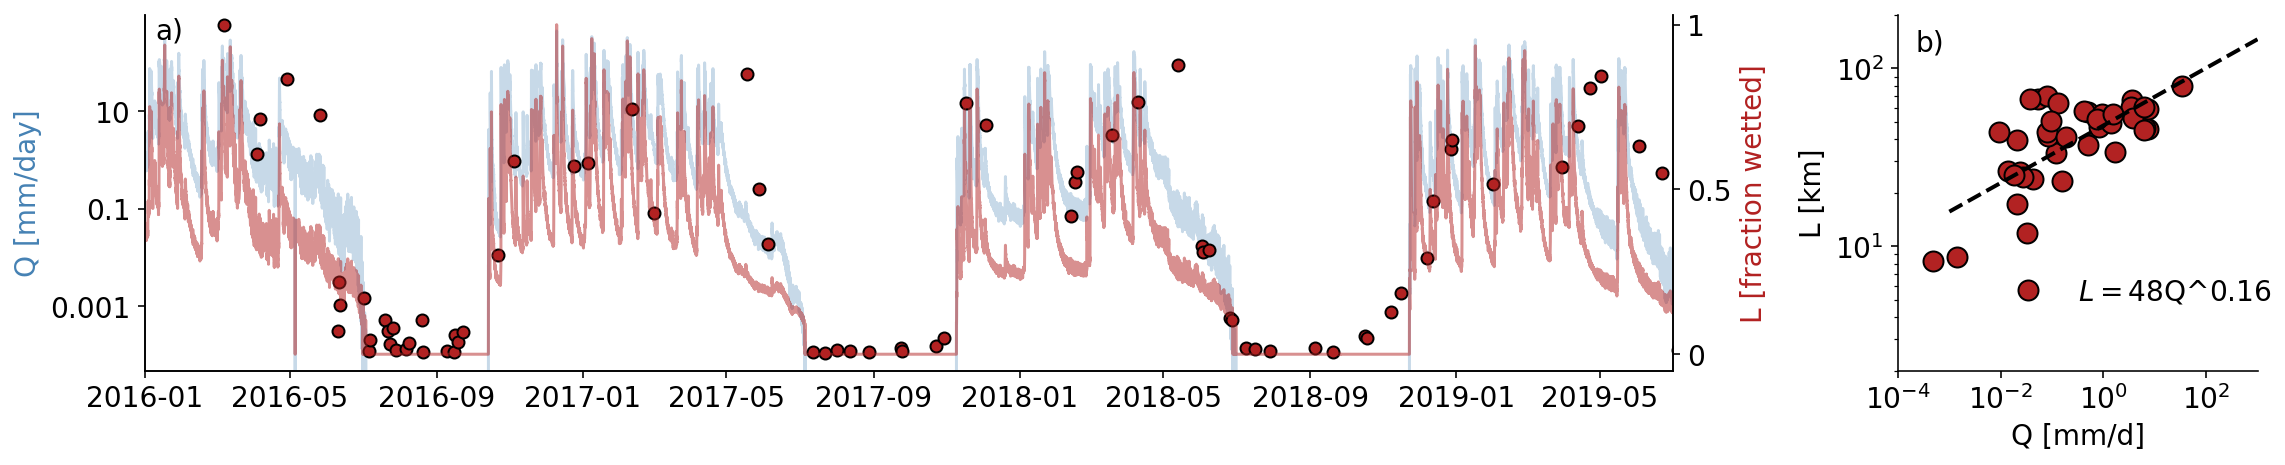

In [16]:
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import datetime

plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize = (16,3.5))
gs = gridspec.GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[:, :-1])
ax2 = fig.add_subplot(gs[:, -1])

ax = ax1
axx = ax1.twinx()
# Plot random forest predicted L points
axx.scatter(Q_and_L.index,(Q_and_L.L/Q_and_L.L.max()),label='L',c='firebrick',ec='k')
# Plot entire predicted timeseries from L Q relation

axx.plot(Q.index,
         (alpha*Q['dryRunoff_mmDay^-1']**beta)/(alpha*Q['dryRunoff_mmDay^-1']**beta).max(),
         c='firebrick',alpha=0.5)
ax.plot(Q.index,Q,label='Q',alpha=0.3,c='steelblue',zorder = -1)
ax.set_yscale('log')
axx.set_ylim(-.05,1.03)
labels = [0,0.5,1,]
axx.set_yticks(labels)
axx.set_yticklabels(labels)
axx.set_ylabel('L [fraction wetted]',c='firebrick')
ax.set_xlim(pd.to_datetime('2016-01-01'),
            pd.to_datetime('2019-07-01'))

ax.set_ylabel('Q [mm/day]',c='steelblue')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

ax.text(pd.to_datetime('2016-01-10'),300,'a)')
ax.spines['top'].set_visible(False)
axx.spines['top'].set_visible(False)



ax = ax2
ax.scatter(Q_and_L['dryRunoff_mmDay^-1'],
            Q_and_L['L'],s = 100,
            edgecolor = 'k',c='firebrick')
xs = np.linspace(1e-3,1e3)
ax.plot(xs,alpha*xs**beta,
        c = 'k',ls='--',lw=2)
ax.set_xlabel('Q [mm/d]')
ax.set_ylabel('L [km]')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlim(.0001,1000)
ax.set_ylim(2,200)
b = '%.2f'%beta
a = '%.0f'%alpha
ax.text(0.5,0.2,r'$L = $'+ a +
        'Q^'+b,transform=ax.transAxes)

ax.text(0.05,.9,'b)',transform=ax.transAxes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()

plt.savefig('Q_and_L.pdf',format='pdf',bbox_inches='tight')

# Logistic regression

In [ ]:
df_alldates['datetime'] = pd.to_datetime(df_alldates.date)
df_alldates = df_alldates.set_index('datetime').sort_index().reset_index()
df_all = pd.merge_asof(df_alldates,Q,left_on='datetime',right_index=True)

In [ ]:

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from scipy.special import expit

# do logit for each node
from sklearn.metrics import log_loss
from scipy.optimize import curve_fit
import scipy.special

def sigmoid(x, x0,b):
  return scipy.special.expit((x-x0)*b)

scale = []
loglo = []
xs = []
ys = []
preds = []

def logfitfun(x):
  X = x['dryRunoff_mmDay^-1'].values[1:]+1e-13
  X = X[:,np.newaxis]
  y = x['predict'].values[1:]
  wetvals = sum(y)
  w = {1:len(y)-wetvals, 0:wetvals}
  clf = LogisticRegression(C=1e5, class_weight=w)
  if all(y==0):
    return(100,0,np.zeros(len(y)))
  elif all(y==1):
    return(0,0,np.ones(len(y)))
  clf.fit(X, y)
  xpred = np.linspace(min(X.flatten())-0.1,max(X.flatten())+0.1,10000).reshape(-1,1)
  ypred = clf.predict(xpred)
  try:
    param = xpred[list(ypred).index(1)]
  except:
    param = [np.nan]
  pred = clf.predict(X)
  pred_mod = clf.predict_proba(X)
  w1 = np.where(y==1,len(y)-wetvals,wetvals)
  logloss = log_loss(y,pred_mod, sample_weight = w1)
  return (param[0]-1e-13,logloss,pred)

df_nozero = df_all.dropna()
df_nozero = df_nozero[pd.to_datetime(df_nozero.date)<pd.to_datetime('2019-05')]
result = df_nozero.groupby(['x','y']).apply(logfitfun)

result = result.to_frame().reset_index()

result['mu'] = [result[0].iloc[i][0] for i in range(len(result))]
result['logloss'] = [result[0].iloc[i][1] for i in range(len(result))]
result['pred'] = [result[0].iloc[i][2] for i in range(len(result))]

temp = result[['x','y','mu']]
temp.loc[temp.mu<=0,'mu'] = np.nan
temp.loc[temp.mu>90,'mu'] = np.nan
temp.to_csv('/content/drive/MyDrive/Sky_Data/mu_predictions.csv')

In [ ]:


g2 = df_all[['area_updated','x','y']].drop_duplicates()

m = g2.merge(temp,on=['x','y'])

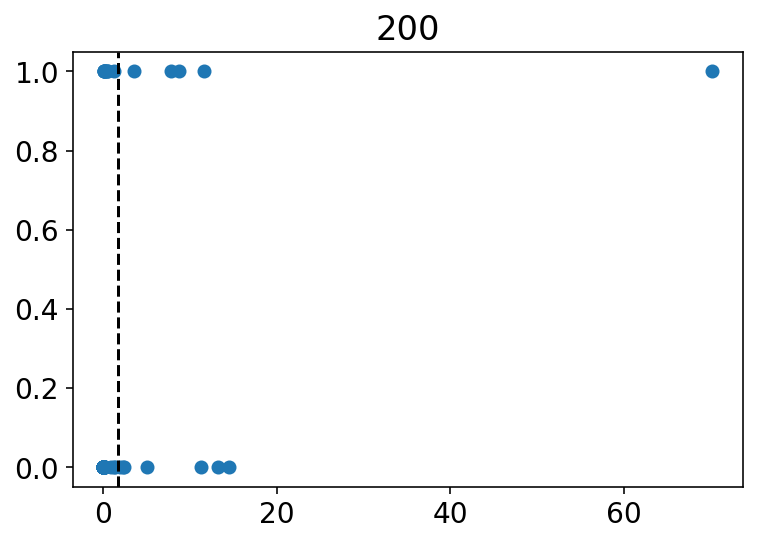

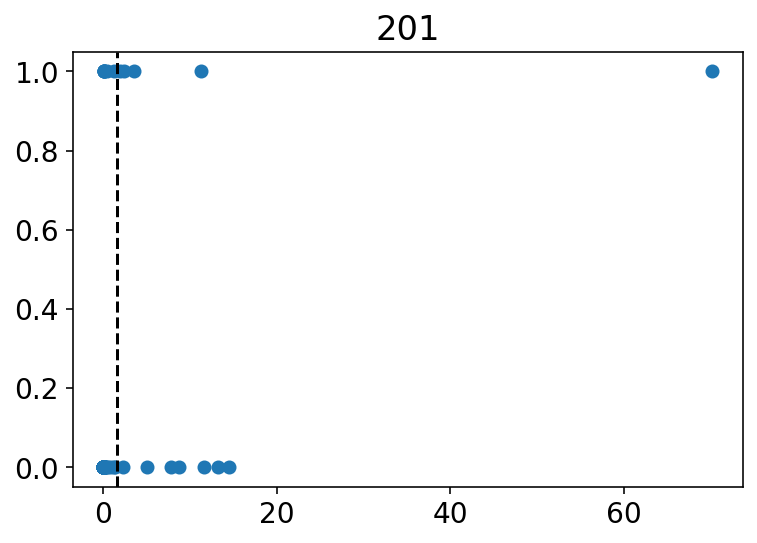

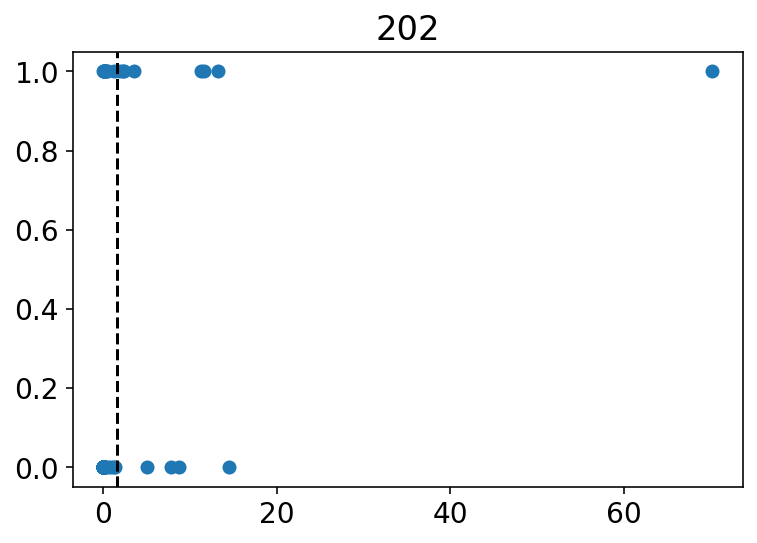

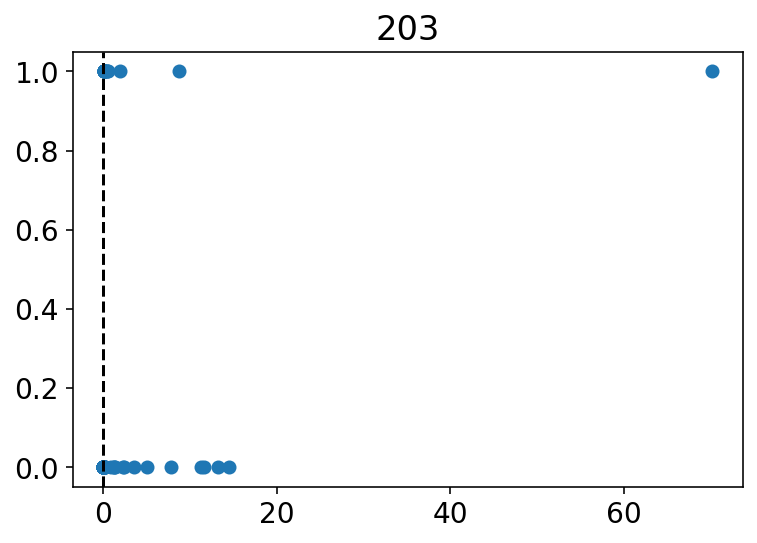

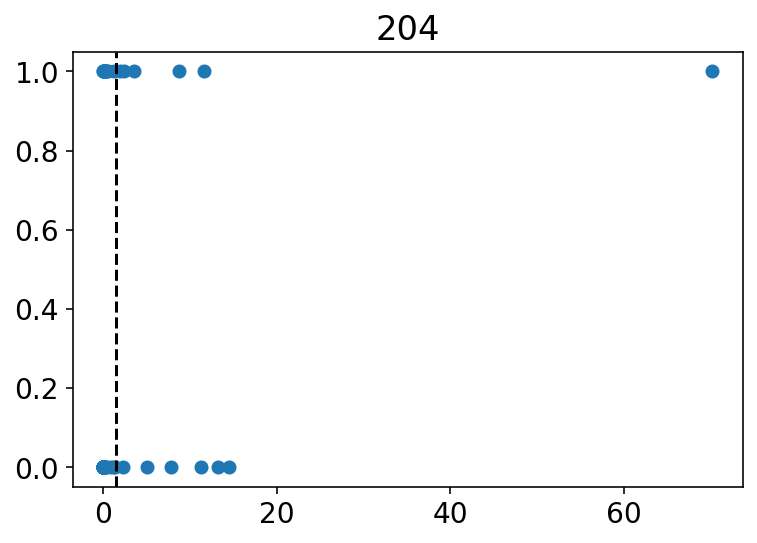

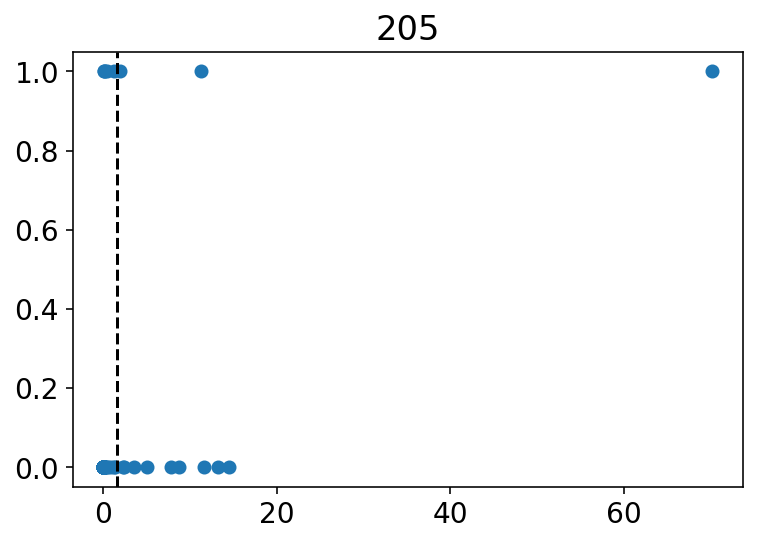

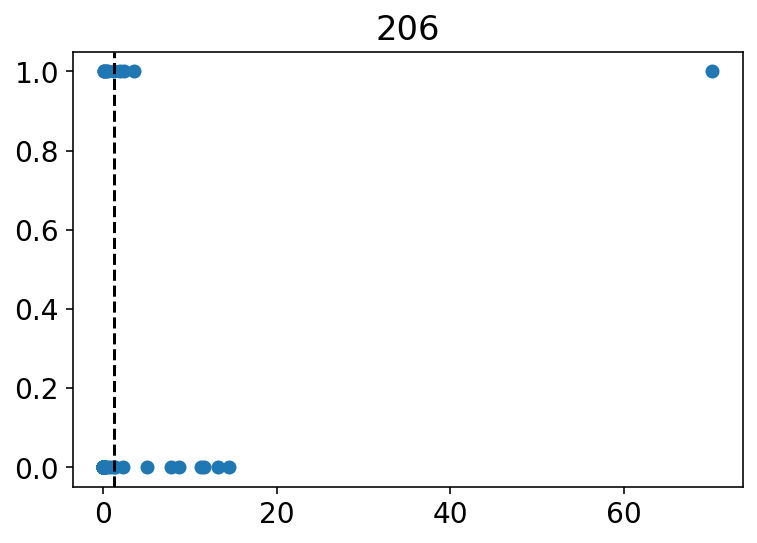

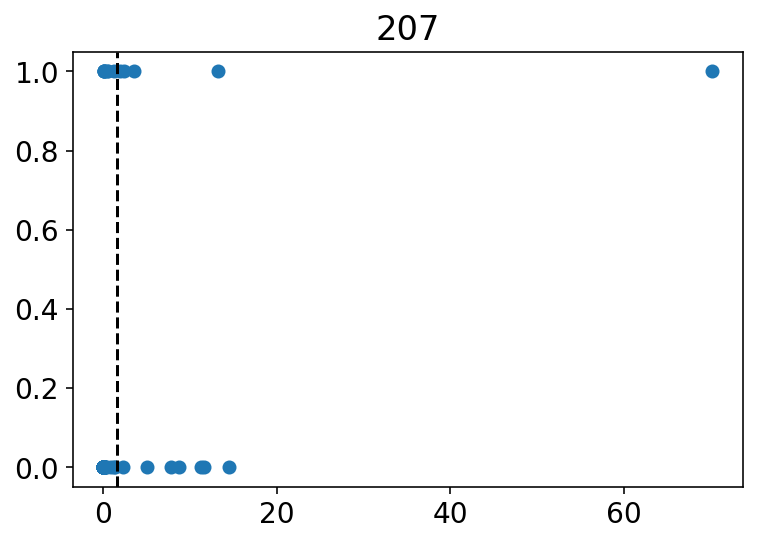

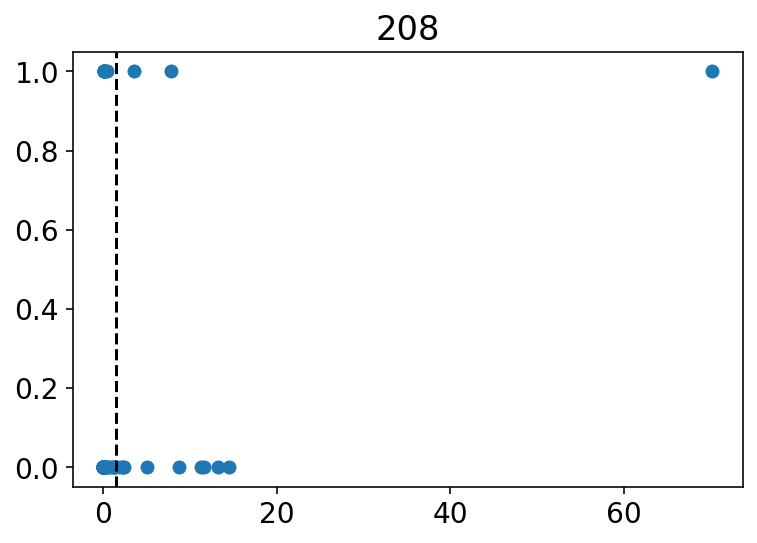

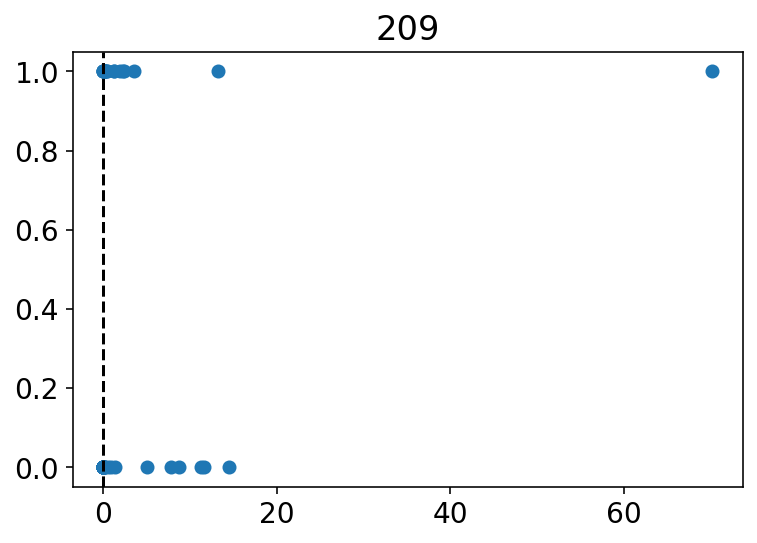

In [ ]:
pts = result[['x','y']].drop_duplicates()

for i in range(200,210):#len(pts)):
  preds = df_all[(df_all.x==pts.x.values[i]) &
              (df_all.y==pts.y.values[i])].predict
  flows = df_all[(df_all.x==pts.x.values[i]) &
              (df_all.y==pts.y.values[i])]['dryRunoff_mmDay^-1']

  zeromask = (preds==0)

  zeroflows = flows[zeromask]
  oneflows = flows[~zeromask]

  fig,ax = plt.subplots(1)
  plt.scatter(flows,preds)
  b=np.linspace(0,10,10)

  ax.axvline(result[(result.x==pts.x.values[i]) &
              (result.y==pts.y.values[i])].mu.values[0],
             ls = '--',c='k')
  plt.title(i)
  plt.show()

In [ ]:
##  LOG LOSS DIAGNOSTIC MAP

# fig,ax = plt.subplots(1,figsize = (12,7))
# im = ax.scatter(result.x,result.y,c=result.logloss,
#             vmin = 0, vmax = 1,
#             s=20)
# cbar = plt.colorbar(im)
# cbar.set_label('Logloss')
# sns.despine()
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

In [ ]:
##  UPSTREAM AREA DIAGNOSTIC MAP


# areaplot = df_alldates[df_alldates.date=='2016-03-07'][['x','y','area_updated']]
# plt.figure(figsize = (20,10))
# im = plt.scatter(areaplot.x,areaplot.y,c=np.log(areaplot.area_updated),s=20)
# plt.colorbar(im)

In [ ]:
## FLOW THRESHOLD MAP 

# plt.figure(figsize = (16,9))


# cmap = plt.cm.plasma#_r  # define the colormap

# # define the bins and normalize
# # bounds = np.logspace(-1,1.3,9)
# bounds = [0.01,0.03,0.1,0.3,1,3,10]#,20,30]
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# cb = plt.scatter(result.x,result.y,c=(result.mu),
#             s=20,cmap=cmap,norm=norm,edgecolor = 'None')
# cbar = plt.colorbar(cb)
# cbar.set_label('Runoff threshold for flow [mm/day] \n (channel hyporheic flow capacity)')
# sns.despine()
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')

Text(0.5, 0, 'mu')

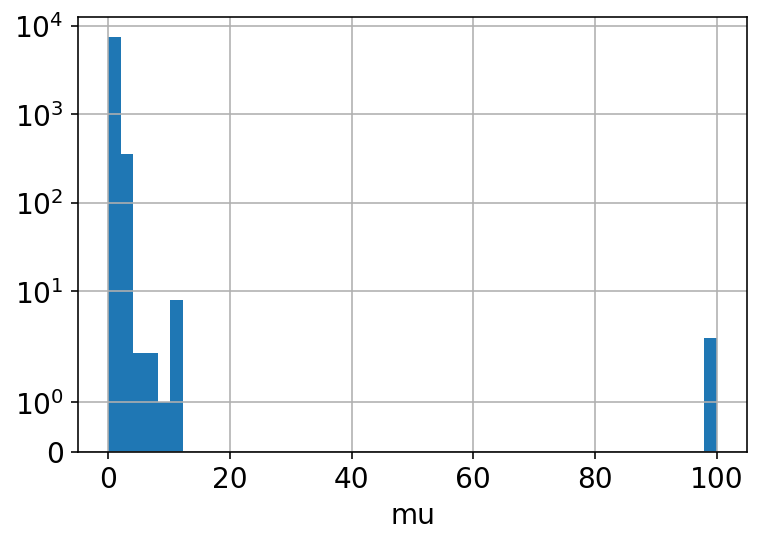

In [ ]:
result.mu.hist(bins = np.linspace(0,100))
plt.yscale('symlog')
plt.xlabel('mu')

# More maps based on logistic regression inferences of when flow state switches from wet to dry

100%|██████████| 7953/7953 [10:09<00:00, 13.06it/s]


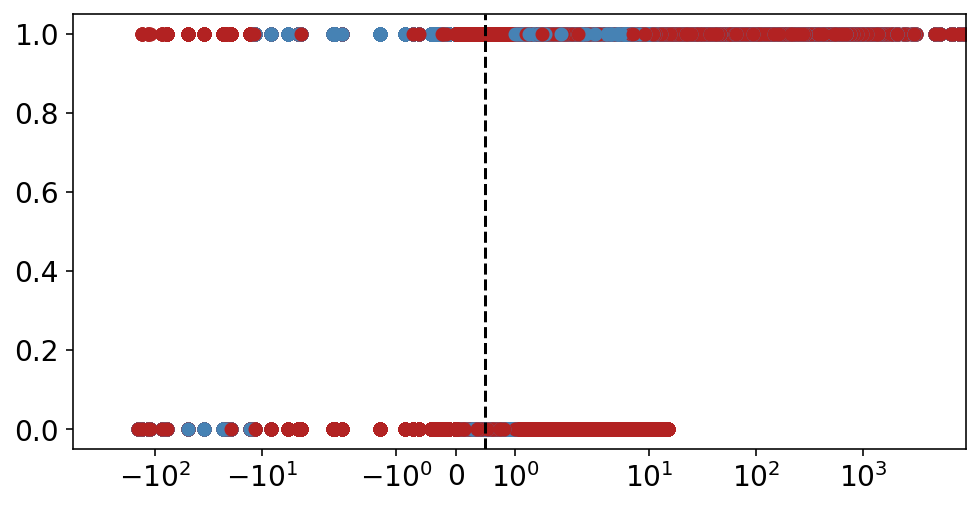

In [ ]:
# OUTPUT SAVED ALREADY, CAN READ IN BELOW. BUT KEEP THIS CELL!

# !pip install -q tqdm
# from tqdm import tqdm
# fig,ax = plt.subplots(1,figsize = (8,4))
# lows = []
# highs = []
# error = []
# for i in tqdm(range(len(result))):
#   # print(i,'of',len(result))
#   # df = df_all[(df_all.x==result.iloc[i].x) &
#   #             (df_all.y==result.iloc[i].y)].dropna().copy()
#   df = df_nozero[(df_nozero.x==result.iloc[i].x) &
#               (df_nozero.y==result.iloc[i].y)].copy().iloc[1:]
#   # df = df[pd.to_datetime(df.date)<pd.to_datetime('2017-05')]
#   try:
#     df['pred'] = result.iloc[i].pred
#     ax.scatter(df['dryRunoff_mmDay^-1']/result.mu.values[i],
#               df.pred,c = 'steelblue',
#               label = 'Logistic regression')
#     ax.scatter(df['dryRunoff_mmDay^-1']/result.mu.values[i],
#               df.predict,
#               c = 'firebrick',
#               label = 'Random forest')
#     low = list(df[df.pred<0.5].predict.values)
#     high = list(df[df.pred>=0.5].predict.values)
#     lows = lows + low
#     highs = highs + high
#   except:
#     error.append(len(df)-len(result.iloc[i].pred))

# # ax.legend()
# ax.axvline(.5,c='k',ls='--')
# ax.set_xscale('symlog')

In [ ]:
# import pickle
# fileObj = open('/content/drive/MyDrive/Sky_Data/highs_lows.pkl', 'wb')
# pickle.dump([lows,highs],fileObj)
# fileObj.close()

In [ ]:
# import saved data from above
import pickle
fileObj = open('/content/drive/MyDrive/Sky_Data/highs_lows.pkl', 'rb')
lows, highs = pickle.load(fileObj)
fileObj.close()

367646 0.5 0.5
81722 1.5 0.5
40026 0.5 1.5
83514 1.5 1.5


Text(0.5, 1.0, 'Confusion matrix for test set')

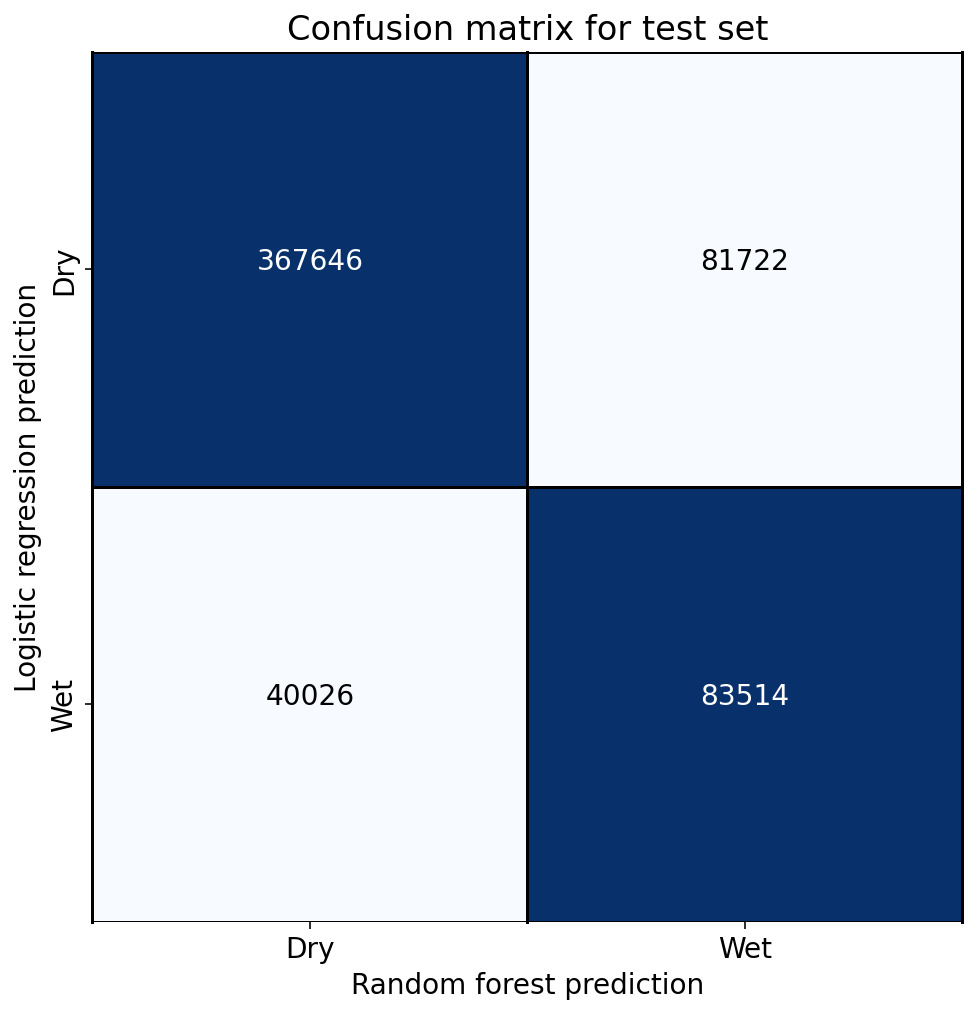

In [ ]:
lowlog_low = sum(np.where(np.array(lows)==0,1,0))
lowlog_high = sum(np.where(np.array(lows)==1,1,0))
highlog_low = sum(np.where(np.array(highs)==0,1,0))
highlog_high = sum(np.where(np.array(highs)==1,1,0))

matvals = [lowlog_low,lowlog_high,highlog_low,highlog_high]

f,ax = plt.subplots(1,  figsize = (8,8))

ax 
sns.heatmap([[1,0],[0,1]], square=True, annot=False,fmt='d', 
            cbar=False,ax=ax, cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['white','k','k','white',]
for i in range(len(matvals)):
  t = matvals[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)
  
ax.set_xlabel('Random forest prediction')
ax.set_ylabel('Logistic regression prediction')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k',clip_on=False)
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')
ax.set_title('Confusion matrix for test set')


367646 0.5 0.5
81722 1.5 0.5
40026 0.5 1.5
83514 1.5 1.5


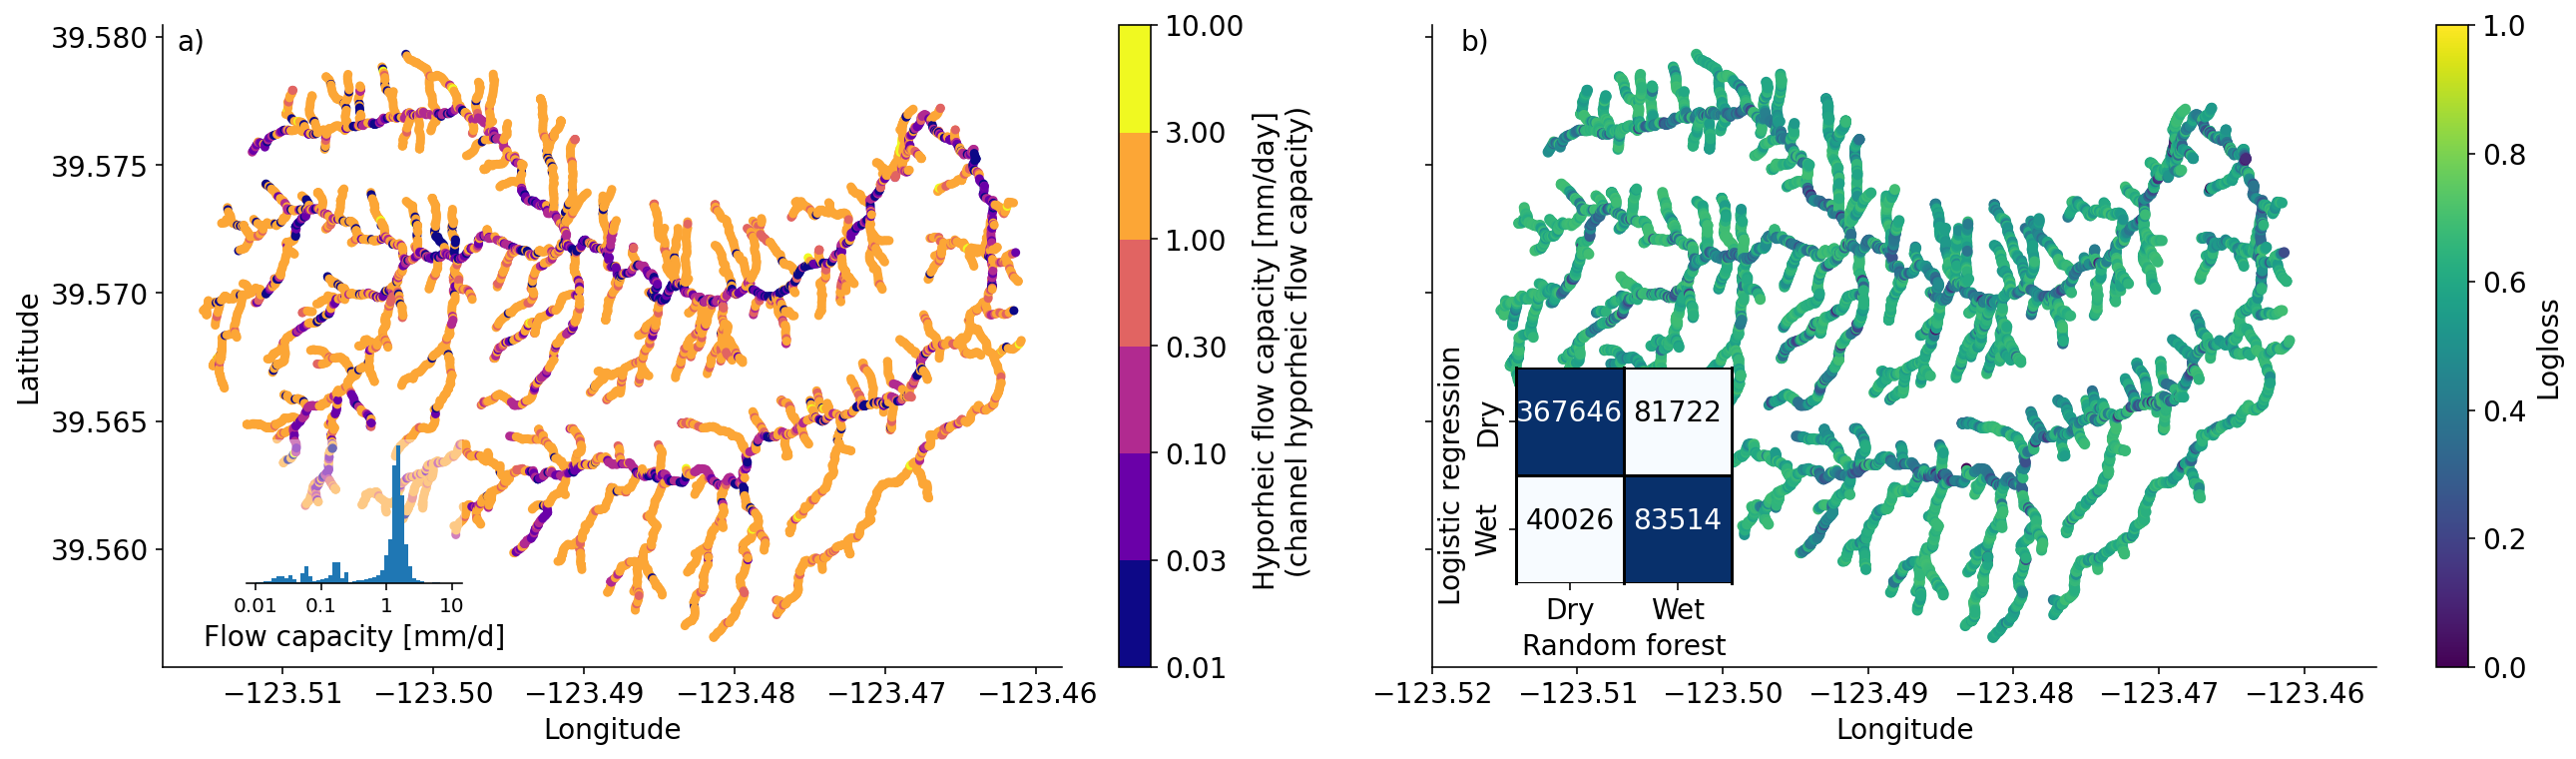

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,axs = plt.subplots(1,2,figsize = (18.5,5.5), 
                       gridspec_kw={'width_ratios': [1,1.05]})

ax = axs[1]
im = ax.scatter(result.x,result.y,c=result.logloss,
            vmin = 0, vmax = 1,
            s=20)
cbar = plt.colorbar(im)
cbar.set_label('Logloss')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels([])
ax.set_xlabel('Longitude')
ax.set_xlim(-123.52,-123.455)


ax = axs[0]
cmap = plt.cm.plasma#_r  # define the colormap

# define the bins and normalize
bounds = [0.01,0.03,0.1,0.3,1,3,10,]#20,30]
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)


cb = ax.scatter(result.x,result.y,c=(result.mu),
            s=20,cmap=cmap,#vmin=0,vmax=30,
            norm=norm,
            edgecolor = 'None')
cbar = plt.colorbar(cb,ax=ax)
cbar.set_label('Hyporheic flow capacity [mm/day] \n (channel hyporheic flow capacity)')
sns.despine()
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

axins = inset_axes(axs[0], width=1.5, height=1., loc='lower left',
                   borderpad = 3.)
axins.hist(result.mu,bins = np.logspace(-2,1.))
axins.set_xscale('log')
axins.set_xlabel('Flow capacity [mm/d]')
axins.spines['right'].set_visible(False)
axins.spines['left'].set_visible(False)
axins.spines['top'].set_visible(False)
axins.set_yticks([])
axins.set_xticks([0.01,0.1,1,10])
axins.set_xticklabels(['0.01','0.1','1','10'],fontsize = 10)
axins.patch.set_alpha(0.4)


axins1 = inset_axes(axs[1], width=1.5, height=1.5, loc=3,
                   borderpad = 3)
ax = axins1
sns.heatmap([[1,0],[0,1]], square=True, annot=False,fmt='d', 
            cbar=False,ax=ax, cmap='Blues')

xlocs = [0.5,1.5,0.5,1.5]
ylocs = [0.5,0.5,1.5,1.5,]
colors = ['white','k','k','white',]
for i in range(len(matvals)):
  t = matvals[i]
  xloc = xlocs[i]
  yloc = ylocs[i]
  color = colors[i]
  print(t,xloc,yloc)
  ax.text(xloc,yloc,t,ha='center',
          c=color,)
  
ax.set_xlabel('Random forest')
ax.set_ylabel('Logistic regression')
ax.set_xticks([0.5,1.5])
ax.set_xticklabels(['Dry','Wet'])
ax.set_yticks([1.5,0.5])
ax.set_yticklabels(['Wet','Dry'])
for x in [0,1,2]:
  ax.plot([x,x],[0,2],c='k',clip_on=False)
for y in [0,1,2]:
  ax.plot([0,2],[y,y],c='k')



fig.tight_layout()

axs[0].text(-123.517,39.5795,'a)',)
axs[1].text(-123.518,39.5795,'b)')

plt.savefig('logistic_fitstats.png',format='png',
            dpi=300,bbox_inches='tight')

## Clip results to nonnegative mu values

In [ ]:
resultsub = result.copy()

resultsub = resultsub[resultsub['mu']>=0]

area = df_all[['x','y','area_updated','slope_percent']].drop_duplicates()
resultsub = resultsub.merge(area,left_on=['x','y'],
                            right_on=['x','y'])
resultsub['slope'] = resultsub['slope_percent']
resultsub['meters_cubed_per_day'] = resultsub['mu']*(0.001 * resultsub['area_updated'].astype(float))
resultsub['slope'] = 0.014*(resultsub.area_updated.astype('float').values/(10**6))**(-0.58)
resultsub['Tw'] = resultsub.meters_cubed_per_day/resultsub.slope

## Volumetric flow capacity

* volumetric discharge as a function of area (flow capacity)
* runoff as a function of area
* volumetric discharge / predicted slope based on power law equation to get cross-section area transmissivity as a function of upslope area

In [ ]:
resultsub.columns

Index([                   'x',                    'y',                      0,
                         'mu',              'logloss',                 'pred',
               'area_updated',        'slope_percent',                'slope',
       'meters_cubed_per_day',                   'Tw'],
      dtype='object')

In [ ]:
# MAKE MAP OF ACTUAL FLOW RATE CAPACITY (not normalized by upstream area)

# 1. get the accumulation area
resultsub = resultsub.merge( df_alldates[df_alldates['date']=='2016-04-03'][['area_updated','x']],left_on='x',right_on='x',how='left')
resultsub['area_updated'] = resultsub['area_updated_x']
# 2. mu is in mm/day. create new column 'flow rate' in :
resultsub['meters_cubed_per_day'] = resultsub['mu']*(0.001 * resultsub['area_updated'].astype(float))
# resultsub.head()

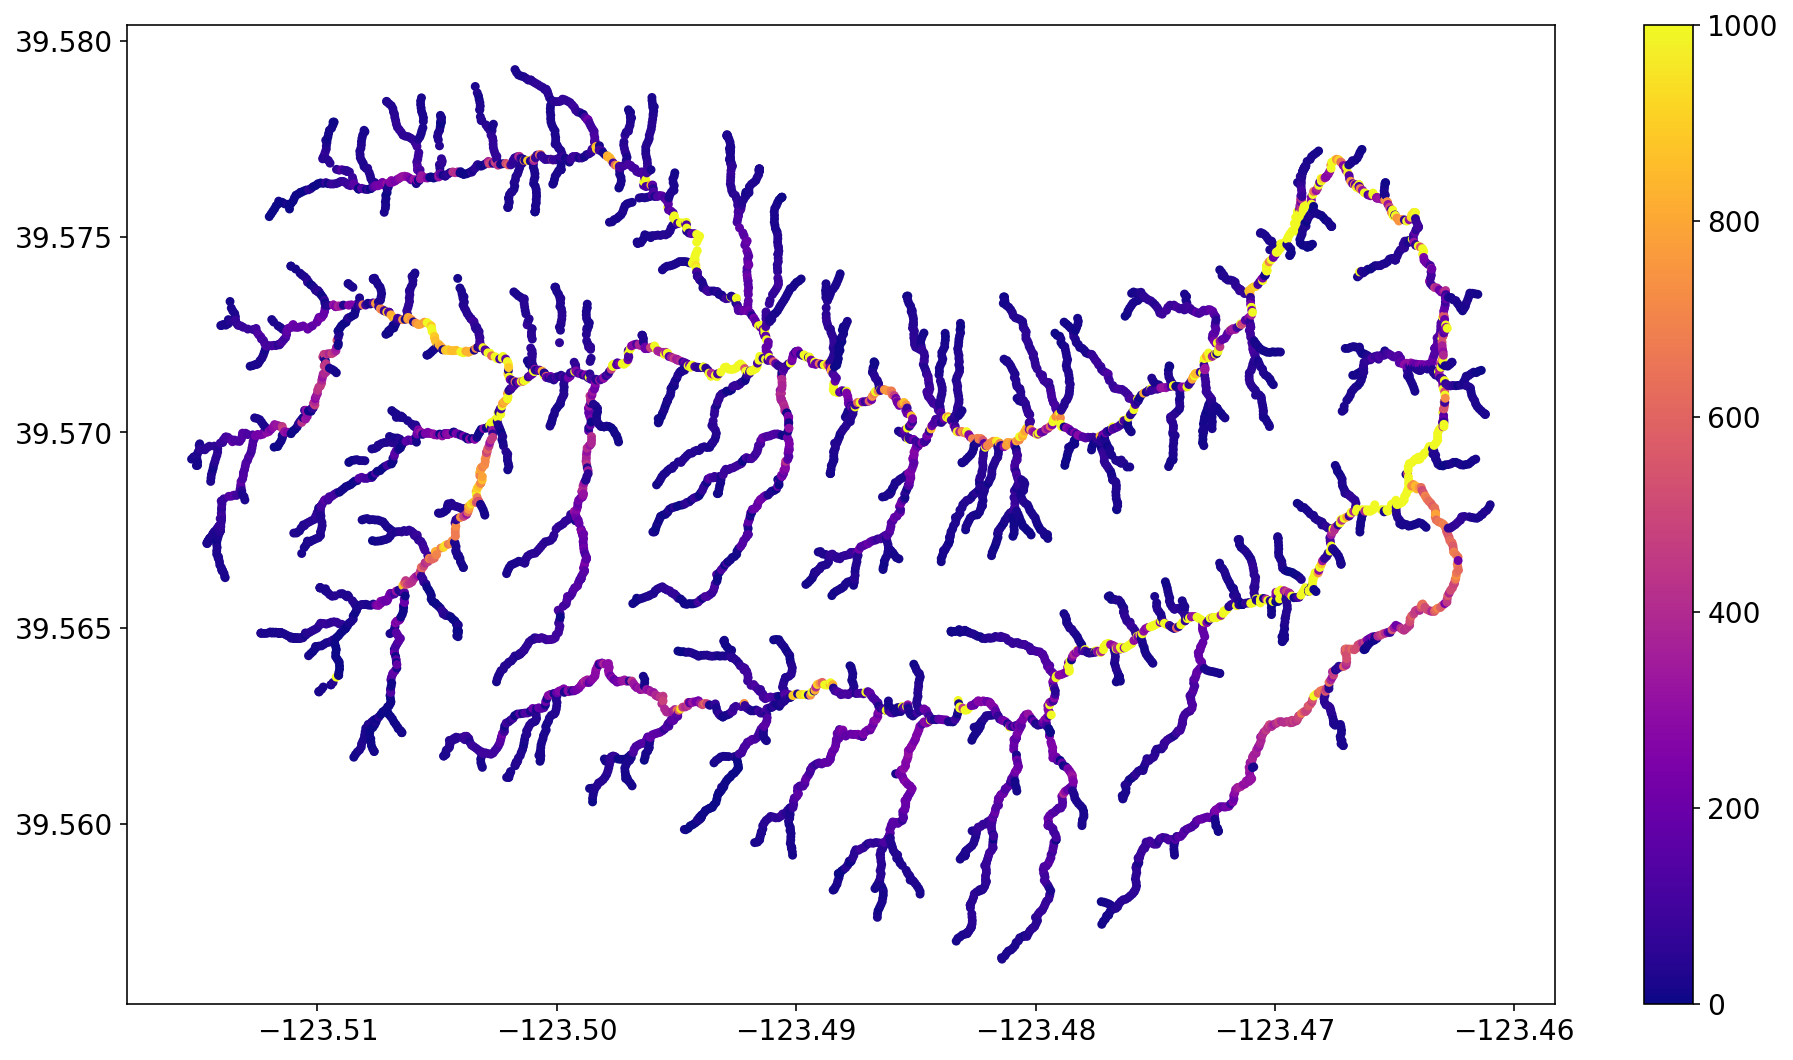

In [ ]:
plt.figure(figsize = (16,9))
plt.scatter(resultsub.x,resultsub.y,c=(resultsub['meters_cubed_per_day']),
            s=20,cmap='plasma',edgecolor = 'None',vmin=0,vmax=1000)
plt.colorbar()

In [ ]:
# add a slope column
resultsub['slope'] = 0.014*(resultsub.area_updated.astype('float').values/(10**6))**(-0.58)
resultsub['Tw'] = resultsub.meters_cubed_per_day/resultsub.slope


## Binning: network hydraulic scaling figure

In [ ]:
#GENERATE BIN SPACING
numBins = 11
area_bins = np.logspace(4,6.3,numBins)
area_bins_mids = .5*(area_bins[1:]+area_bins[:-1])
#Return the indices of the bins to which each value in input array belongs.
area_indices = np.digitize(resultsub['area_updated'].values, area_bins)


#COMPUTE MEAN, MEDIAN AND STANDARD DEVIATION OF VALUE OF INTEREST IN EACH BIN
slope_bin_means = [resultsub['slope'].values[area_indices == i].mean() for i in range(1, len(area_bins))]
slope_bin_medians = [np.median( resultsub['slope'].values[area_indices == i]) for i in range(1, len(area_bins))]
slope_bin_stds = [resultsub['slope'].values[area_indices == i].std() for i in range(1, len(area_bins))]
slope_bin_25th = [np.nanpercentile(resultsub['slope'].values[area_indices == i], 25) for i in range(1, len(area_bins))]
slope_bin_75th = [np.nanpercentile(resultsub['slope'].values[area_indices == i], 75) for i in range(1, len(area_bins))]

runoff_bin_means = [resultsub['mu'].values[area_indices == i].mean() for i in range(1, len(area_bins))]
runoff_bin_medians = [np.median(resultsub['mu'].values[area_indices == i]) for i in range(1, len(area_bins))]
runoff_bin_stds = [resultsub['mu'].values[area_indices == i].std() for i in range(1, len(area_bins))]
runoff_bin_25th = [np.nanpercentile(resultsub['mu'].values[area_indices == i], 25) for i in range(1, len(area_bins))]
runoff_bin_75th = [np.nanpercentile(resultsub['mu'].values[area_indices == i], 75) for i in range(1, len(area_bins))]


discharge_bin_means = [resultsub['meters_cubed_per_day'].values[area_indices == i].mean() for i in range(1, len(area_bins))]
discharge_bin_medians = [np.median(resultsub['meters_cubed_per_day'].values[area_indices == i]) for i in range(1, len(area_bins))]
discharge_bin_stds = [resultsub['meters_cubed_per_day'].values[area_indices == i].std() for i in range(1, len(area_bins))]
discharge_bin_25th = [np.nanpercentile(resultsub['meters_cubed_per_day'].values[area_indices == i], 25) for i in range(1, len(area_bins))]
discharge_bin_75th = [np.nanpercentile(resultsub['meters_cubed_per_day'].values[area_indices == i], 75) for i in range(1, len(area_bins))]

trans_bin_means = [resultsub['Tw'].values[area_indices == i].mean() for i in range(1, len(area_bins))]
trans_bin_medians = [np.median(resultsub['Tw'].values[area_indices == i]) for i in range(1, len(area_bins))]
trans_bin_stds = [resultsub['Tw'].values[area_indices == i].std() for i in range(1, len(area_bins))]
trans_bin_25th = [np.nanpercentile(resultsub['Tw'].values[area_indices == i], 25) for i in range(1, len(area_bins))]
trans_bin_75th = [np.nanpercentile(resultsub['Tw'].values[area_indices == i], 75) for i in range(1, len(area_bins))]




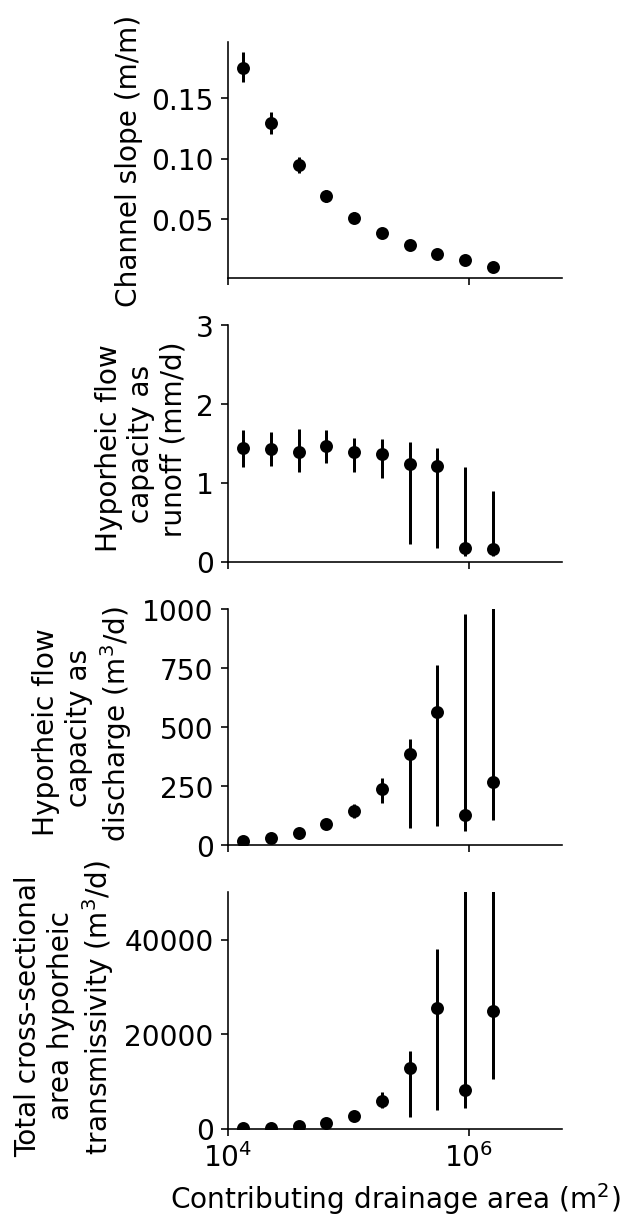

In [ ]:
f, ax = plt.subplots(4,1,figsize=(3,10),sharex=True) 

plotError=True
symbolSize = 30

# CHANNEL SLOPE
ax[0].scatter(area_bins_mids,
              slope_bin_medians, 
              s=symbolSize, marker = "o", color = 'k')
ax[0].set_ylabel('Channel slope (m/m)')

# FLOW CAPACITY AS RUNOFF
ax[1].scatter(area_bins_mids,
              runoff_bin_medians, 
              s=symbolSize, marker = "o", color = 'k')
ax[1].set_ylabel('Hyporheic flow \n capacity as \n runoff (mm/d)')
ax[1].set_ylim(0,3)

# FLOW CAPACITY AS DISCHARGE
ax[2].scatter(area_bins_mids,
              discharge_bin_medians, 
              s=symbolSize, marker = "o", color = 'k')
ax[2].set_ylabel('Hyporheic flow \n capacity as \n discharge (m$^3$/d)')
ax[2].set_ylim(0,1000)

# TOTAL HYPORHEIC TRANSMISSIVITY
ax[3].scatter(area_bins_mids,
              trans_bin_medians, 
              s=symbolSize, marker = "o", color = 'k')
ax[3].set_ylabel('Total cross-sectional \narea hyporheic \n transmissivity (m$^3$/d)')
ax[3].set_ylim(0,50000)

if plotError:
    ax[0].errorbar(area_bins_mids,
                   slope_bin_medians, 
                   yerr=[np.array(slope_bin_medians)-np.array(slope_bin_25th),
                         np.array(slope_bin_75th)-np.array(slope_bin_medians)], 
                   c='k', capthick=0, ecolor = 'k',linestyle='')
    ax[1].errorbar(area_bins_mids,
                   runoff_bin_medians, 
                   yerr=[np.array(runoff_bin_medians)-np.array(runoff_bin_25th),
                         np.array(runoff_bin_75th)-np.array(runoff_bin_medians)], 
                   c='k', capthick=0, ecolor = 'k',linestyle='')
    ax[2].errorbar(area_bins_mids,
                   discharge_bin_medians, 
                   yerr=[np.array(discharge_bin_medians)-np.array(discharge_bin_25th),
                         np.array(discharge_bin_75th)-np.array(discharge_bin_medians)], 
                   c='k', capthick=0, ecolor = 'k',linestyle='')  
    ax[3].errorbar(area_bins_mids,
                   trans_bin_medians, 
                   yerr=[np.array(trans_bin_medians)-np.array(trans_bin_25th),
                         np.array(trans_bin_75th)-np.array(trans_bin_medians)], 
                   c='k', capthick=0, ecolor = 'k',linestyle='')  

  
sns.despine()
ax[-1].set_xlabel('Contributing drainage area (m$^2$)')
ax[-1].set_xscale('log')
plt.xlim(10000,6000000)
plt.savefig("bins.pdf", transparent=True, bbox_inches='tight')

## Exceedance probability / time based inferences

In [ ]:
WY_2017_Q = Q.copy()#[Q.index>='2016-10']
# WY_2017_Q = WY_2017_Q[WY_2017_Q.index<'2017-10']
WY_2017_Q = WY_2017_Q.fillna(0)
WY_2017_Q = WY_2017_Q.resample('1D').mean()

In [ ]:


WY_2017_Q = WY_2017_Q.sort_values('dryRunoff_mmDay^-1')
WY_2017_Q['exceedance'] = (np.arange(1.,len(WY_2017_Q)+1) / len(WY_2017_Q))*100
WY_2017_Q 


mu_cdf = resultsub.copy()


mu_cdf = mu_cdf.sort_values('mu')
mu_cdf['exceedance'] = (np.arange(1.,len(mu_cdf)+1) / len(mu_cdf))*100

In [ ]:
pers =[]
for i in range(len(resultsub)):
  active_days = WY_2017_Q['dryRunoff_mmDay^-1'] >= resultsub.iloc[i]['mu'] 
  pers.append(active_days.sum()/len(WY_2017_Q))
resultsub['persistence'] = pers

In [ ]:
# get L exceedance probability... by determining node values > or < flow... 

WY_2017_Q['L'] = np.nan

for i, row in WY_2017_Q.iterrows():
  active_L = resultsub['mu'] < (row['dryRunoff_mmDay^-1'])
  WY_2017_Q.loc[i]['L'] = active_L.sum()

                                                                            
WY_2017_Q['L_frac'] = WY_2017_Q['L']/WY_2017_Q['L'].max()

In [ ]:
active_L.sum()

7791

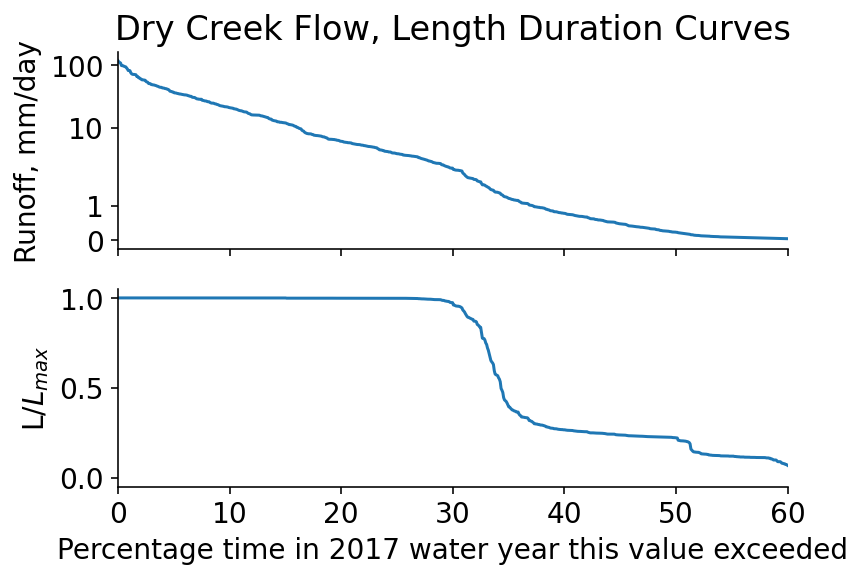

In [ ]:


fig,ax=plt.subplots(2,1,sharex=True)

ax[0].plot(100-WY_2017_Q['exceedance'],WY_2017_Q['dryRunoff_mmDay^-1'])
ax[0].set_yscale('symlog')

ax[0].set_title('Dry Creek Flow, Length Duration Curves')
ax[0].set_ylabel('Runoff, mm/day')
plt.xlabel('Percentage time in 2017 water year this value exceeded')

ax[1].plot(100-WY_2017_Q['exceedance'],WY_2017_Q['L_frac'])

ax[1].set_ylabel('L/$L_{max}$')


ax[0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
ax[1].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
sns.despine()
plt.xlim(0,60)
plt.savefig('duration_curves.pdf')

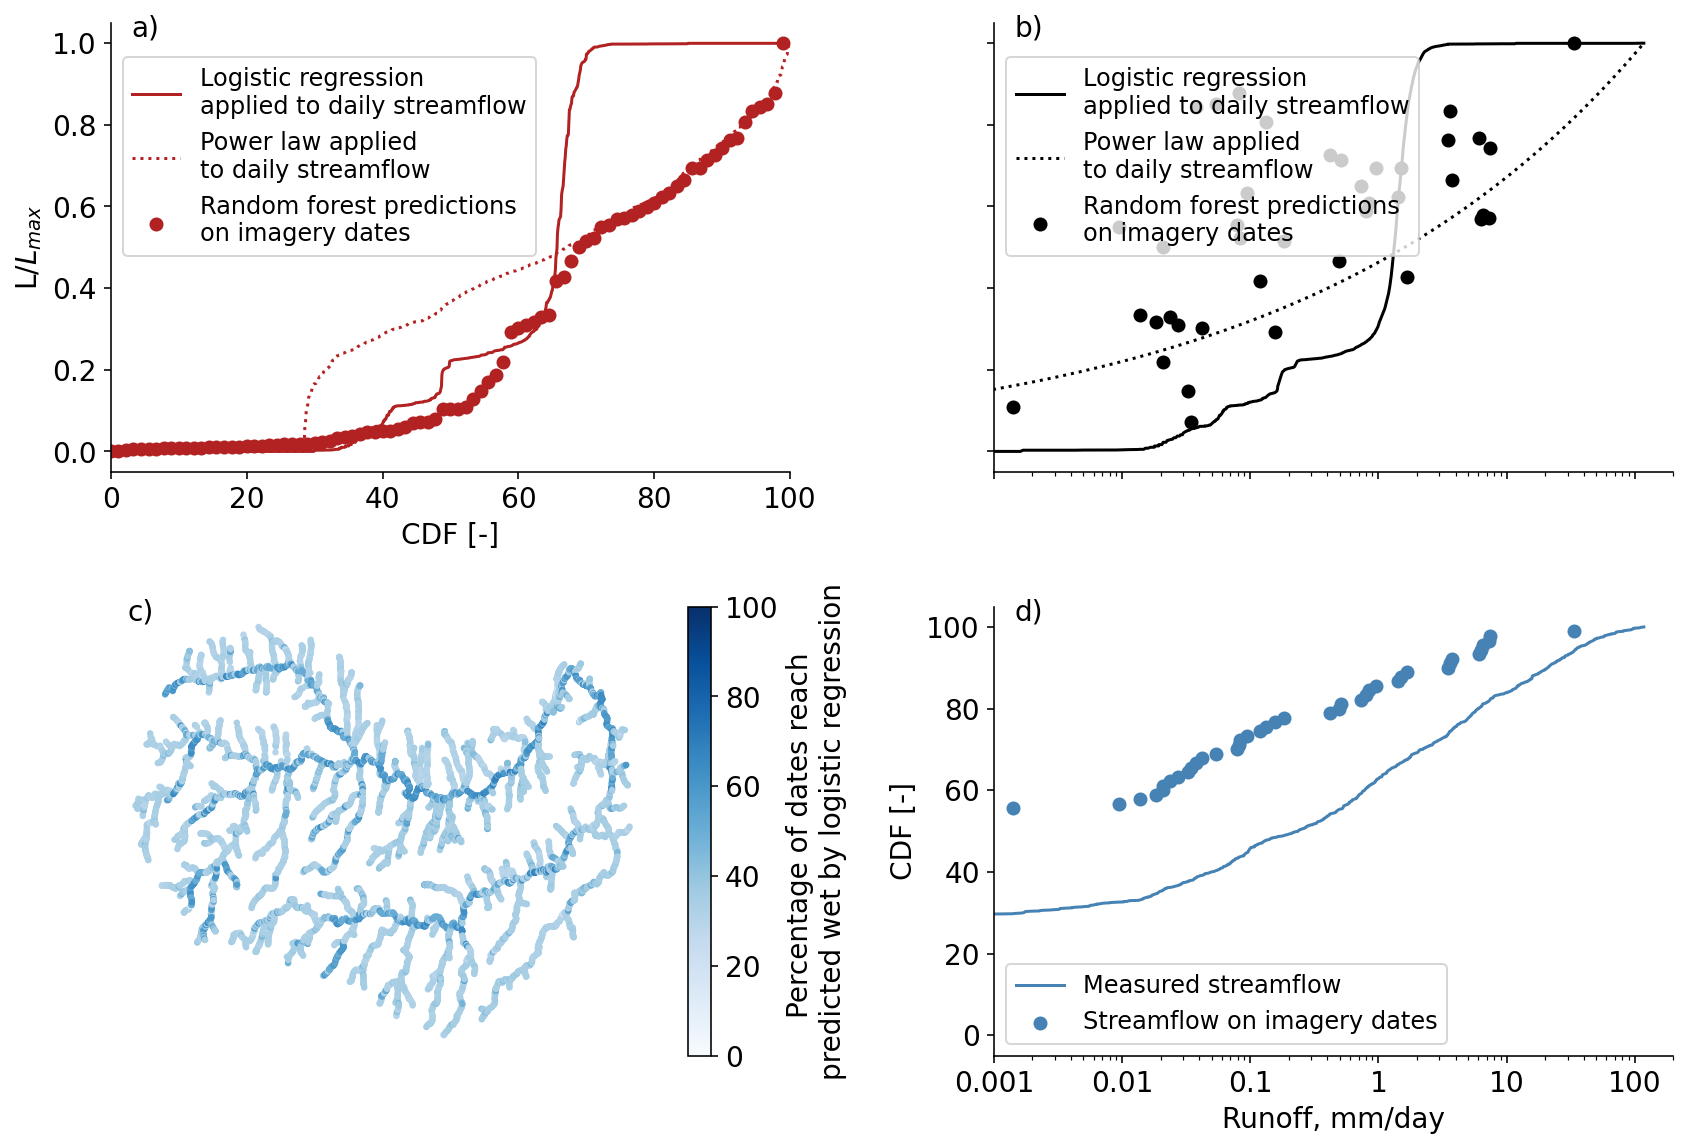

In [ ]:
from matplotlib.patches import ConnectionPatch

fs =12
logitlabel = 'Logistic regression\napplied to daily streamflow'
powerlabel = 'Power law applied\nto daily streamflow'
rflabel = 'Random forest predictions\non imagery dates'

QL = Q.copy().resample('D').mean()
QL['Lpred'] = (alpha*QL['dryRunoff_mmDay^-1']**beta)/(alpha*QL['dryRunoff_mmDay^-1']**beta).max()

fig,axs=plt.subplots(2,2,figsize = (14,9.5))
size = 20
ax = axs[1][1]
ax.plot(WY_2017_Q['dryRunoff_mmDay^-1'],
        WY_2017_Q['exceedance'],c='steelblue',
        label = 'Measured streamflow')
ps = np.array(list(range(len(WY_2017_Q))))/len(WY_2017_Q)*100

ax.set_xscale('log')
ps = np.array(list(range(len(QL))))/len(QL)*100


ps1 = np.array(list(range(len(Q_and_L))))/len(Q_and_L)*100
ax.scatter(Q_and_L['dryRunoff_mmDay^-1'].sort_values(),ps1,
               c='steelblue',
           label = 'Streamflow on imagery dates'
               )


ax.set_xlabel('Runoff, mm/day')
ax.set_ylabel('CDF [-]')
ax.set_xlim(0.001,200)
ax.legend(fontsize = fs)

import matplotlib.ticker as ticker
import numpy as np

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y,pos: ('{{:.{:1d}f}}'.format(int(np.maximum(-np.log10(y),0)))).format(y)))


ax = axs[0][0]
ax.plot(WY_2017_Q['exceedance'],WY_2017_Q['L_frac'],
        c = 'firebrick', label =logitlabel)
ax.set_xlim(0,100)
ps = np.array(list(range(len(WY_2017_Q))))/len(WY_2017_Q)*100

ps1 = np.array(list(range(len(Q_and_L))))/len(Q_and_L)*100
ax.scatter(ps1,Q_and_L['L'].sort_values()/Q_and_L.L.max(),
               c='firebrick',
           label = rflabel
           )


ax.set_ylabel('L/$L_{max}$')
ax.set_xlabel('CDF [-]')
ps = np.array(list(range(len(QL))))/len(QL)*100
ax.plot(ps,QL['Lpred'].sort_values(),
         c='firebrick',ls=':',
        label = powerlabel)
ax.legend(fontsize = fs,loc='upper left',
          bbox_to_anchor = (0,0.95))

ax = axs[0][1]
ax.plot(WY_2017_Q['dryRunoff_mmDay^-1'].sort_values().values,
           WY_2017_Q['L_frac'].sort_values().values,
           c = 'k',
           label = logitlabel)

ax.plot(QL['dryRunoff_mmDay^-1'].sort_values().values,
        QL.Lpred.sort_values().values,label = powerlabel,
        c= 'k', ls = ':')

ax.scatter(Q_and_L['dryRunoff_mmDay^-1'],
           Q_and_L.L/Q_and_L.L.max(),
           c='k',label=rflabel)

ax.legend(fontsize = fs,bbox_to_anchor = (0,0.95),
          loc = 'upper left')

ax.set_xscale('log')
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(0.001,200)

axs[1][1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))
axs[0][0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))



ax = axs[1][0]
im = ax.scatter(resultsub.x,resultsub.y,c=resultsub.persistence*100,
                s = 5, cmap = 'Blues',
           vmin = 0,
           vmax = 100)

cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Percentage of dates reach \npredicted wet by logistic regression')


ax.axis('off')


axs[0][0].annotate("a)", xy=(0.03, 0.97), xycoords="axes fraction")
axs[0][1].annotate("b)", xy=(0.03, 0.97), xycoords="axes fraction")
axs[1][0].annotate("c)", xy=(0.03, 0.97), xycoords="axes fraction")
axs[1][1].annotate("d)", xy=(0.03, 0.97), xycoords="axes fraction")


sns.despine()
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.savefig('duration_curves.pdf')